# DHAdam Optimizer
### Course Project by Lavanya, Rushil, Sartaj, Shreya (L1P2)
### Computational Methods and Optimization, Monsoon 2025 



--- PROJECT 1: OPTIMIZER EVALUATION ---
Novel Optimizer: DH-Adam (Dual-Horizon Adam)

########################################
# 1. Well-Conditioned Quadratic (Dim=10, $\kappa$=10, Target < 1e-06)
########################################
| Optimizer       | Iterations to Target | Final Loss (f(x))    |
|:---------------|:---------------------|:---------------------|
| DH-Adam        | 694             | 8.594045e-07   |
| Adam           | 6730            | 9.930357e-07   |
| SGD+Momentum   | 5506            | 9.993962e-07   |
| Simple GD      | MAX_ITER (10000) | 2.895254e-06   |

########################################
# 2. Ill-Conditioned Quadratic (Dim=10, $\kappa$=100, Target < 1e-06)
########################################
| Optimizer       | Iterations to Target | Final Loss (f(x))    |
|:---------------|:---------------------|:---------------------|
| DH-Adam        | 875             | 9.804702e-07   |
| Adam           | 8230            | 9.848535e-07   |
| SGD+Momentum   | MA

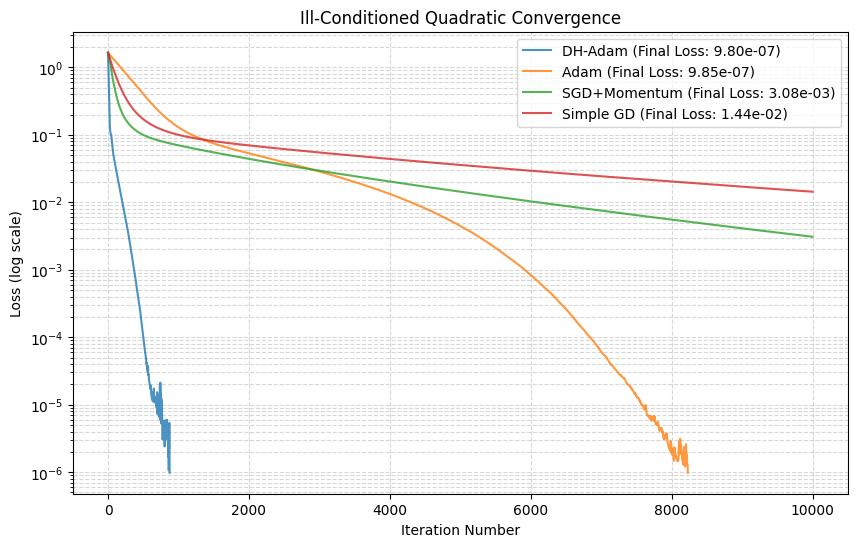


########################################
# 3. Rosenbrock Function (Target < 1e-04, Start=[-1.2  1. ])
########################################
| Optimizer       | Iterations to Target | Final Loss (f(x))    |
|:---------------|:---------------------|:---------------------|
| DH-Adam        | 1807            | 9.934536e-05   |
| Adam           | MAX_ITER (10000) | 3.678027e-04   |
| SGD+Momentum   | 836             | 9.963927e-05   |
| Simple GD      | MAX_ITER (10000) | 7.880389e-01   |


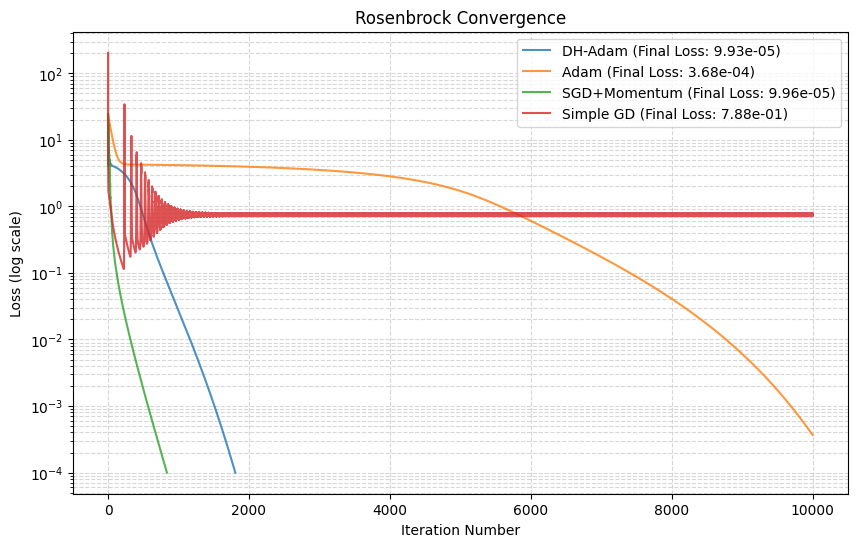


############################################################
# 4. MNIST Neural Network Training
############################################################
Architecture: 784-128-64-10
Batch Size: 64
Epochs: 20
############################################################


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.33MB/s]


Training with DH-Adam...
Epoch 5/20, Loss: 0.2404, Test Accuracy: 96.72%
Epoch 10/20, Loss: 0.1961, Test Accuracy: 96.92%
Epoch 15/20, Loss: 0.1762, Test Accuracy: 96.99%
Epoch 20/20, Loss: 0.1659, Test Accuracy: 97.32%
Training with Adam...
Epoch 5/20, Loss: 0.2464, Test Accuracy: 96.24%
Epoch 10/20, Loss: 0.2020, Test Accuracy: 96.84%
Epoch 15/20, Loss: 0.1805, Test Accuracy: 97.12%
Epoch 20/20, Loss: 0.1716, Test Accuracy: 97.12%
Training with SGD+Momentum...
Epoch 5/20, Loss: 0.2338, Test Accuracy: 96.68%
Epoch 10/20, Loss: 0.1895, Test Accuracy: 97.12%
Epoch 15/20, Loss: 0.1683, Test Accuracy: 97.36%
Epoch 20/20, Loss: 0.1583, Test Accuracy: 97.35%
Training with Simple GD...
Epoch 5/20, Loss: 1.1398, Test Accuracy: 82.72%
Epoch 10/20, Loss: 0.7657, Test Accuracy: 88.12%
Epoch 15/20, Loss: 0.6260, Test Accuracy: 89.99%
Epoch 20/20, Loss: 0.5524, Test Accuracy: 90.96%
Training with RMSprop...
Epoch 5/20, Loss: 0.2712, Test Accuracy: 96.21%
Epoch 10/20, Loss: 0.2339, Test Accuracy: 9

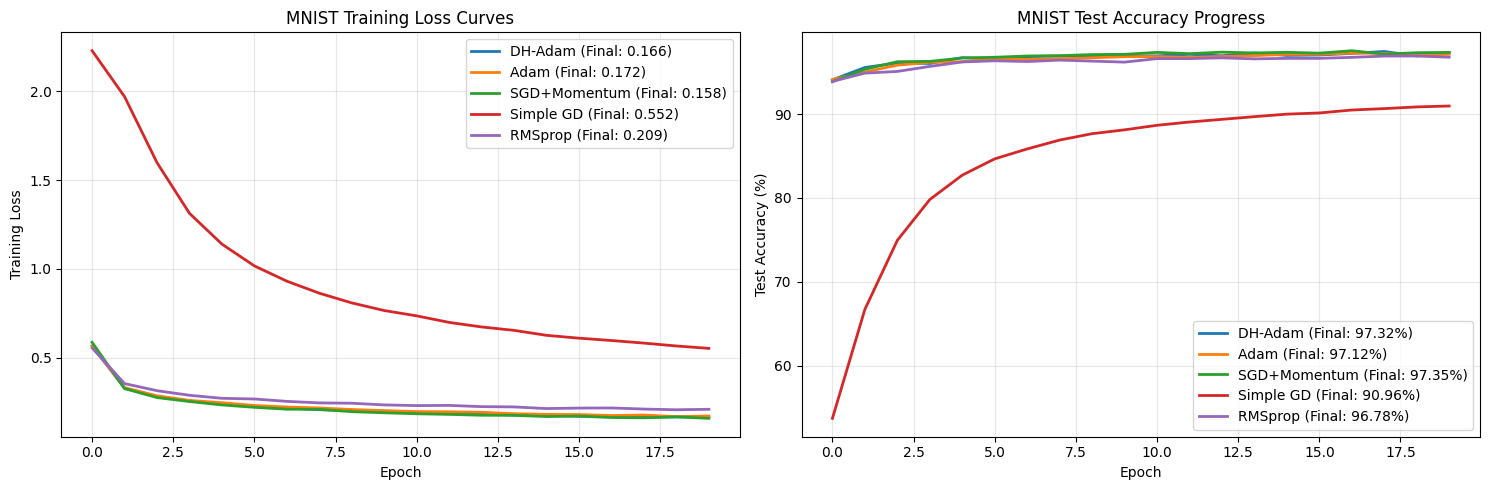


ALL BENCHMARKS COMPLETED!


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from typing import Dict, Any, Callable, Tuple, List

# --- 1. OPTIMIZER CLASSES ---

class BaseOptimizer:
    """Base class defining the interface for all optimizers."""
    def __init__(self, params: Dict[str, Any]):
        self.params = params
        self.state = {}
        self.t = 0
        self.name = "Base"

    def initialize(self, x0: np.ndarray):
        """Initializes state variables based on starting point x0."""
        self.state = {}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        """Performs one step of optimization. Must be implemented by subclasses."""
        raise NotImplementedError

class DHAdam(BaseOptimizer):
    """
    Dual-Horizon Adam (DH-Adam) Optimizer.
    Uses fast and slow moments to adapt update direction based on divergence (noise/instability).
    """
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "DH-Adam"

    def initialize(self, x0: np.ndarray):
        dim = x0.shape[0]
        self.state = {
            'fastM': np.zeros(dim),
            'fastV': np.zeros(dim),
            'slowM': np.zeros(dim),
            'slowV': np.zeros(dim),
            'confidence': 1.0
        }
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        timeStep = self.t
        eps = 1e-8

        # Unpack parameters
        lr = self.params.get('lr', 0.01)
        fb1, fb2 = self.params.get('fastBeta1', 0.9), self.params.get('fastBeta2', 0.999)
        sb1, sb2 = self.params.get('slowBeta1', 0.995), self.params.get('slowBeta2', 0.9998)
        tau = self.params.get('divergenceThreshold', 2.0)
        beta_conf = self.params.get('confidenceBeta', 0.9)

        # 1. Update raw fast/slow moments
        self.state['fastM'] = fb1 * self.state['fastM'] + (1 - fb1) * grad
        self.state['fastV'] = fb2 * self.state['fastV'] + (1 - fb2) * grad**2
        self.state['slowM'] = sb1 * self.state['slowM'] + (1 - sb1) * grad
        self.state['slowV'] = sb2 * self.state['slowV'] + (1 - sb2) * grad**2

        # 2. Bias correction
        fastMHat = self.state['fastM'] / (1 - fb1**timeStep)
        fastVHat = self.state['fastV'] / (1 - fb2**timeStep)
        slowMHat = self.state['slowM'] / (1 - sb1**timeStep)
        slowVHat = self.state['slowV'] / (1 - sb2**timeStep)

        # 3. Normalized Divergence (D_t): Compares moment estimates relative to stable scale
        divergence = np.linalg.norm(fastMHat - slowMHat) / (np.linalg.norm(np.sqrt(slowVHat)) + eps)

        # 4. Raw Confidence (C_raw)
        rawConf = 1.0 / (1.0 + (divergence / tau))

        # 5. Smooth Confidence (C_t)
        self.state['confidence'] = beta_conf * self.state['confidence'] + (1 - beta_conf) * rawConf

        # 6. Calculate the adaptive Adam updates
        updateFast = fastMHat / (np.sqrt(fastVHat) + eps)
        updateSlow = slowMHat / (np.sqrt(slowVHat) + eps)

        # 7. Blend the final update direction based on Confidence
        blendedUpdate = self.state['confidence'] * updateFast + (1 - self.state['confidence']) * updateSlow

        # 8. Final step
        X_new = X - lr * blendedUpdate
        return X_new

class Adam(BaseOptimizer):
    """Standard Adam optimizer (Baseline 1)."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "Adam"

    def initialize(self, x0: np.ndarray):
        dim = x0.shape[0]
        self.state = {'m': np.zeros(dim), 'v': np.zeros(dim)}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        timeStep = self.t
        eps = 1e-8

        # Use fastBeta for standard Adam parameters
        beta1, beta2 = self.params.get('fastBeta1', 0.9), self.params.get('fastBeta2', 0.999)
        lr = self.params.get('lr', 0.001) # Use the base LR defined in the run parameters

        # 1. Update moments
        self.state['m'] = beta1 * self.state['m'] + (1 - beta1) * grad
        self.state['v'] = beta2 * self.state['v'] + (1 - beta2) * grad**2

        # 2. Bias correction
        mHat = self.state['m'] / (1 - beta1**timeStep)
        vHat = self.state['v'] / (1 - beta2**timeStep)

        # 3. Final step
        update = mHat / (np.sqrt(vHat) + eps)
        X_new = X - lr * update
        return X_new

class SGD(BaseOptimizer):
    """SGD with Momentum (Baseline 2)."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "SGD+Momentum"

    def initialize(self, x0: np.ndarray):
        dim = x0.shape[0]
        self.state = {'v': np.zeros(dim)} # Velocity vector
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        lr = self.params.get('sgd_lr', 0.01) # Separate LR for SGD
        beta = self.params.get('sgd_momentum', 0.9)

        # 1. Update velocity (momentum)
        self.state['v'] = beta * self.state['v'] + (1 - beta) * grad

        # 2. Final step
        X_new = X - lr * self.state['v']
        return X_new

class GradientDescent(BaseOptimizer):
    """Simple Gradient Descent (Baseline 3)."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "Simple GD"

    def initialize(self, x0: np.ndarray):
        self.state = {}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        lr = self.params.get('gd_lr', 0.001) # Separate LR for Simple GD

        # 1. Final step: X_new = X - lr * grad
        X_new = X - lr * grad
        return X_new

# --- 2. PROBLEM DEFINITIONS (f(x) and grad(x)) ---

def generate_quadratic_problem(dim: int, condition_number: float) -> Tuple[Callable, Callable, np.ndarray]:
    """
    Generates a quadratic function f(x) = 1/2 * x^T Q x with a specified condition number.
    Condition number (kappa) = max_eigenvalue / min_eigenvalue.
    """
    # Create eigenvalues (Lambda) from max/min values
    max_eig = 1.0
    min_eig = max_eig / condition_number

    # Generate log-spaced eigenvalues to ensure the condition number holds
    eigenvalues = np.logspace(np.log10(min_eig), np.log10(max_eig), dim)

    # Create a random orthogonal matrix R for rotation
    Q = np.random.randn(dim, dim)
    Q, _ = np.linalg.qr(Q)

    # Construct the final matrix Q = R * Lambda * R^T
    Q = Q @ np.diag(eigenvalues) @ Q.T

    def func(X: np.ndarray) -> float:
        return 0.5 * X.T @ Q @ X

    def grad(X: np.ndarray) -> np.ndarray:
        return Q @ X

    # Starting point (randomly initialized near a point of high loss)
    x0 = np.random.randn(dim) * 5 / np.sqrt(dim)

    return func, grad, x0

# Rosenbrock function (Fixed 2D problem)
def rosenbrock_func(X: np.ndarray) -> float:
    a, b = 1.0, 100.0
    x, y = X[0], X[1]
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(X: np.ndarray) -> np.ndarray:
    a, b = 1.0, 100.0
    x, y = X[0], X[1]
    # df/dx
    g_x = -2 * (a - x) - 4 * b * x * (y - x**2)
    # df/dy
    g_y = 2 * b * (y - x**2)
    return np.array([g_x, g_y])

# --- 3. EVALUATION FRAMEWORK ---

def evaluate_optimizer(
    optimizer: BaseOptimizer,
    f: Callable,
    grad_fn: Callable,
    x0: np.ndarray,
    target_loss: float,
    max_iter: int = 10000,
    noise_level: float = 0.0
) -> Tuple[int, float, List[float]]:
    """Runs the optimizer until the target loss is reached or max_iter is hit."""

    X = x0.copy()
    optimizer.initialize(x0)
    loss_history = []

    for t in range(max_iter):
        current_loss = f(X)
        loss_history.append(current_loss)

        if current_loss < target_loss:
            return t, current_loss, loss_history

        # Calculate true gradient and add noise
        true_grad = grad_fn(X)
        noisy_grad = true_grad + noise_level * np.random.randn(X.shape[0])

        # Take optimization step
        X = optimizer.step(X, noisy_grad)

    final_loss = f(X)
    loss_history.append(final_loss)
    return max_iter, final_loss, loss_history

def format_results(name, iterations, final_loss, target_loss):
    if iterations < 10000:
        return f"| {name:<14} | {iterations:<15} | {final_loss:<14.6e} |"
    else:
        return f"| {name:<14} | {'MAX_ITER (10000)':<15} | {final_loss:<14.6e} |"

def plot_convergence_curves(curves: Dict[str, List[float]], title: str):
    """Plots the loss history for all optimizers on a log scale."""
    plt.figure(figsize=(10, 6))
    for name, history in curves.items():
        # Ensure finite values for log scale
        history_clean = np.maximum(np.array(history), 1e-10)
        plt.plot(history_clean, label=f'{name} (Final Loss: {history[-1]:.2e})', alpha=0.8)

    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

# --- MNIST NEURAL NETWORK CLASSES ---

class MNISTNet(nn.Module):
    """Neural network for MNIST classification: 784-128-64-10"""
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class TorchDHAdam(optim.Optimizer):
    """PyTorch implementation of DH-Adam optimizer"""

    def __init__(self, params, lr=0.001, beta1_fast=0.9, beta1_slow=0.995,
                 beta2_fast=0.999, beta2_slow=0.999, tau=2.0, beta_conf=0.9,
                 eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, beta1_fast=beta1_fast, beta1_slow=beta1_slow,
                        beta2_fast=beta2_fast, beta2_slow=beta2_slow, tau=tau,
                        beta_conf=beta_conf, eps=eps, weight_decay=weight_decay)
        super(TorchDHAdam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('DH_Adam does not support sparse gradients')

                # State initialization
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    # Fast moments
                    state['fastM'] = torch.zeros_like(p.data)
                    state['fastV'] = torch.zeros_like(p.data)
                    # Slow moments
                    state['slowM'] = torch.zeros_like(p.data)
                    state['slowV'] = torch.zeros_like(p.data)
                    # Confidence state
                    state['confidence'] = torch.tensor(0.5)

                state['step'] += 1
                beta1_fast, beta1_slow = group['beta1_fast'], group['beta1_slow']
                beta2_fast, beta2_slow = group['beta2_fast'], group['beta2_slow']
                tau, beta_conf = group['tau'], group['beta_conf']
                eps = group['eps']

                # Weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                # Update fast moments
                state['fastM'].mul_(beta1_fast).add_(grad, alpha=1 - beta1_fast)
                state['fastV'].mul_(beta2_fast).addcmul_(grad, grad, value=1 - beta2_fast)

                # Update slow moments
                state['slowM'].mul_(beta1_slow).add_(grad, alpha=1 - beta1_slow)
                state['slowV'].mul_(beta2_slow).addcmul_(grad, grad, value=1 - beta2_slow)

                # Bias correction
                t = state['step']
                bias_correction1_fast = 1 - beta1_fast ** t
                bias_correction2_fast = 1 - beta2_fast ** t
                bias_correction1_slow = 1 - beta1_slow ** t
                bias_correction2_slow = 1 - beta2_slow ** t

                m_hat_fast = state['fastM'] / bias_correction1_fast
                v_hat_fast = state['fastV'] / bias_correction2_fast
                m_hat_slow = state['slowM'] / bias_correction1_slow
                v_hat_slow = state['slowV'] / bias_correction2_slow

                # Compute normalized divergence
                diff_m = m_hat_fast - m_hat_slow
                if diff_m.dim() > 1:
                    divergence_numerator = torch.norm(diff_m, p='fro')
                    sqrt_v_slow = torch.sqrt(v_hat_slow)
                    divergence_denominator = torch.norm(sqrt_v_slow, p='fro') + eps
                else:
                    divergence_numerator = torch.norm(diff_m, p=2)
                    sqrt_v_slow = torch.sqrt(v_hat_slow)
                    divergence_denominator = torch.norm(sqrt_v_slow, p=2) + eps

                D_t = divergence_numerator / divergence_denominator

                # Raw confidence score
                C_raw = 1.0 / (1.0 + D_t / tau)
                C_raw = torch.clamp(C_raw, 0.0, 1.0)

                # Smoothed confidence
                state['confidence'] = beta_conf * state['confidence'] + (1 - beta_conf) * C_raw

                # Compute update directions
                update_fast = m_hat_fast / (torch.sqrt(v_hat_fast) + eps)
                update_slow = m_hat_slow / (torch.sqrt(v_hat_slow) + eps)

                # Blended update
                C_t = state['confidence']
                update_blended = C_t * update_fast + (1 - C_t) * update_slow

                # Parameter update
                p.data.add_(update_blended, alpha=-group['lr'])

        return loss

def train_mnist_model(optimizer_name, optimizer_fn, num_epochs=20, batch_size=64):
    """Train MNIST model with specified optimizer and return results"""

    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Model and optimizer
    model = MNISTNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model.parameters())

    train_losses = []
    test_accuracies = []
    start_time = time.time()

    print(f"Training with {optimizer_name}...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Testing phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    training_time = time.time() - start_time

    return {
        'final_accuracy': test_accuracies[-1],
        'training_time': training_time,
        'train_losses': train_losses,
        'test_accuracies': test_accuracies
    }

def run_mnist_benchmark():
    """Run MNIST neural network training benchmark"""

    print("\n" + "#"*60)
    print("# 4. MNIST Neural Network Training")
    print("#"*60)
    print("Architecture: 784-128-64-10")
    print("Batch Size: 64")
    print("Epochs: 20")
    print("#"*60)

    # Define optimizers for comparison
    optimizers_config = {
        'DH-Adam': {
            'fn': lambda params: TorchDHAdam(params, lr=0.001, beta1_fast=0.9, beta1_slow=0.995,
                                             beta2_fast=0.999, beta2_slow=0.999, tau=2.0, beta_conf=0.9)
        },
        'Adam': {
            'fn': lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999))
        },
        'SGD+Momentum': {
            'fn': lambda params: optim.SGD(params, lr=0.01, momentum=0.9)
        },
        'Simple GD': { # Simple Gradient Descent
            'fn': lambda params: optim.SGD(params, lr=0.001, momentum=0.0)
        },
        'RMSprop': {
            'fn': lambda params: optim.RMSprop(params, lr=0.001)
        }
    }

    results = {}

    # Train with each optimizer
    for name, config in optimizers_config.items():
        results[name] = train_mnist_model(name, config['fn'], num_epochs=20, batch_size=64)

    # Print results table
    print("\n" + "="*80)
    print("MNIST Training Results (After 20 Epochs)")
    print("="*80)
    print("| Optimizer       | Test Accuracy | Training Time | Final Loss |")
    print("|:---------------|:-------------:|:-------------:|:----------:|")

    for name, metrics in results.items():
        final_loss = metrics['train_losses'][-1]
        print(f"| {name:<14} | {metrics['final_accuracy']:>12.2f}% | {metrics['training_time']:>11.2f}s | {final_loss:>9.4f} |")

    # Plot training curves
    plot_mnist_results(results)

    return results

def plot_mnist_results(results):
    """Plot MNIST training results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Training loss curves
    for name, metrics in results.items():
        ax1.plot(metrics['train_losses'], label=f'{name} (Final: {metrics["train_losses"][-1]:.3f})', linewidth=2)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('MNIST Training Loss Curves')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Test accuracy curves
    for name, metrics in results.items():
        ax2.plot(metrics['test_accuracies'], label=f'{name} (Final: {metrics["final_accuracy"]:.2f}%)', linewidth=2)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy (%)')
    ax2.set_title('MNIST Test Accuracy Progress')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mnist_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- MAIN FUNCTION TO RUN ALL BENCHMARKS ---

def run_all_benchmarks(optimizer_class: BaseOptimizer, dh_adam_params: Dict[str, Any]):
    """Sets up and runs all four benchmarks including MNIST"""

    print("\n" + "="*80)
    print("--- PROJECT 1: OPTIMIZER EVALUATION ---")
    print("Novel Optimizer: DH-Adam (Dual-Horizon Adam)")
    print("="*80)

    # Base parameters for all tests
    base_params = {
        'lr': 0.001,
        'fastBeta1': 0.9,
        'fastBeta2': 0.999,
        'sgd_lr': 0.01,
        'sgd_momentum': 0.9,
        'gd_lr': 0.005, # Simple GD Learning Rate
    }

    # Combine base params with DH-Adam specific novel parameters
    full_dh_params = {**base_params, **dh_adam_params}

    # Define optimizers for comparison - ADDED GradientDescent
    optimizers = [
        DHAdam(full_dh_params),
        Adam(base_params),
        SGD(base_params),
        GradientDescent(base_params), # New Baseline
    ]

    # --- Benchmark 1 & 2: Quadratic Problems (Dimension = 10) ---
    DIM = 10
    NOISE = 0.001
    TARGET_QUAD = 1e-6
    MAX_ITER = 10000

    # 1. Well-conditioned (kappa=10)
    f_wc, grad_wc, x0_wc = generate_quadratic_problem(DIM, condition_number=10)

    print("\n" + "#"*40)
    print(f"# 1. Well-Conditioned Quadratic (Dim={DIM}, $\\kappa$=10, Target < {TARGET_QUAD:.0e})")
    print("#"*40)
    print("| Optimizer       | Iterations to Target | Final Loss (f(x))    |")
    print("|:---------------|:---------------------|:---------------------|")

    for opt in optimizers:
        iters, final_loss, _ = evaluate_optimizer(opt, f_wc, grad_wc, x0_wc, TARGET_QUAD, MAX_ITER, noise_level=NOISE)
        print(format_results(opt.name, iters, final_loss, TARGET_QUAD))

    # 2. Ill-conditioned (kappa=100)
    f_ic, grad_ic, x0_ic = generate_quadratic_problem(DIM, condition_number=100)

    print("\n" + "#"*40)
    print(f"# 2. Ill-Conditioned Quadratic (Dim={DIM}, $\\kappa$=100, Target < {TARGET_QUAD:.0e})")
    print("#"*40)
    print("| Optimizer       | Iterations to Target | Final Loss (f(x))    |")
    print("|:---------------|:---------------------|:---------------------|")

    convergence_curves = {}
    for opt in optimizers:
        iters, final_loss, loss_history = evaluate_optimizer(opt, f_ic, grad_ic, x0_ic, TARGET_QUAD, MAX_ITER, noise_level=NOISE)
        print(format_results(opt.name, iters, final_loss, TARGET_QUAD))
        convergence_curves[opt.name] = loss_history

    # Plot convergence
    plot_convergence_curves(convergence_curves, "Ill-Conditioned Quadratic Convergence")


    # --- Benchmark 3: Rosenbrock Function (Fixed 2D) ---
    F_RB, GRAD_RB = rosenbrock_func, rosenbrock_grad
    X0_RB = np.array([-1.2, 1.0])
    TARGET_RB = 1e-4
    NOISE_RB = 0.0

    print("\n" + "#"*40)
    print(f"# 3. Rosenbrock Function (Target < {TARGET_RB:.0e}, Start={X0_RB})")
    print("#"*40)
    print("| Optimizer       | Iterations to Target | Final Loss (f(x))    |")
    print("|:---------------|:---------------------|:---------------------|")

    convergence_curves_rb = {}
    for opt in optimizers:
        iters, final_loss, loss_history = evaluate_optimizer(opt, F_RB, GRAD_RB, X0_RB, TARGET_RB, MAX_ITER, noise_level=NOISE_RB)
        print(format_results(opt.name, iters, final_loss, TARGET_RB))
        convergence_curves_rb[opt.name] = loss_history

    plot_convergence_curves(convergence_curves_rb, "Rosenbrock Convergence")


    # --- Benchmark 4: MNIST Neural Network Training ---
    mnist_results = run_mnist_benchmark()

    print("\n" + "="*80)
    print("ALL BENCHMARKS COMPLETED!")
    print("="*80)

if __name__ == '__main__':
    # DH-Adam Novel Parameters
    dh_adam_novel_params = {
        'lr': 0.03,
        'divergenceThreshold': 2.0,
        'slowBeta1': 0.995,
        'slowBeta2': 0.9998,
        'confidenceBeta': 0.9,
    }
    run_all_benchmarks(DHAdam, dh_adam_novel_params)


--- BENCHMARK FOCUS: WELL-CONDITIONED QUADRATIC ---

##################################################
# Well-Conditioned Quadratic (Dim=10, $\kappa$=10, Target < 1e-06)
##################################################
| Optimizer       | Iterations to Target | Final Loss (f(x))    |
|:---------------|:---------------------|:---------------------|
| DH-Adam        | 643             | 9.480105e-07   |
| Adam           | 6481            | 9.981239e-07   |
| SGD+Momentum   | 5192            | 9.989899e-07   |
| Simple GD      | MAX_ITER (10000) | 2.171525e-06   |


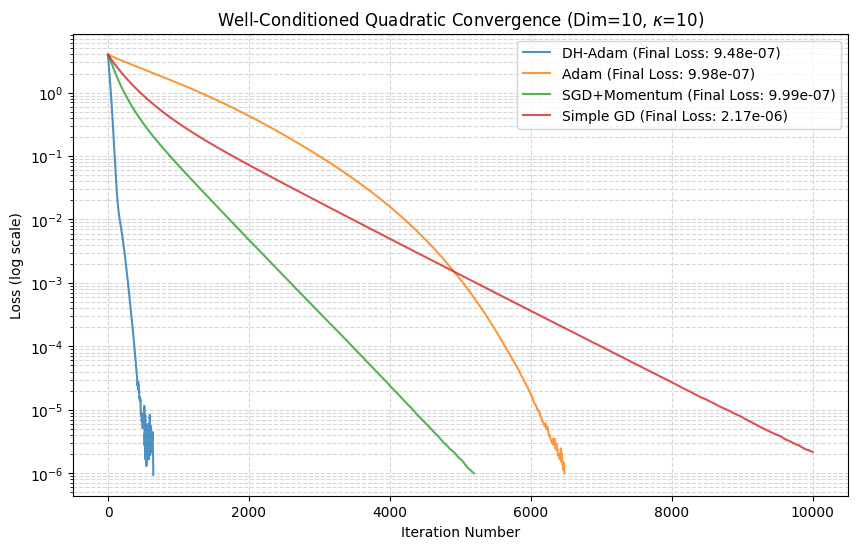

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, Callable, Tuple, List

# --- 1. OPTIMIZER CLASSES (NumPy Implementation) ---

class BaseOptimizer:
    """Base class defining the interface for all optimizers."""
    def __init__(self, params: Dict[str, Any]):
        self.params = params
        self.state = {}
        self.t = 0
        self.name = "Base"

    def initialize(self, x0: np.ndarray):
        self.state = {}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class DHAdam(BaseOptimizer):
    """Dual-Horizon Adam (DH-Adam) Optimizer."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "DH-Adam"

    def initialize(self, x0: np.ndarray):
        dim = x0.shape[0]
        self.state = {
            'fastM': np.zeros(dim),
            'fastV': np.zeros(dim),
            'slowM': np.zeros(dim),
            'slowV': np.zeros(dim),
            'confidence': 1.0
        }
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        timeStep = self.t
        eps = 1e-8

        # Unpack parameters
        lr = self.params.get('lr', 0.01)
        fb1, fb2 = self.params.get('fastBeta1', 0.9), self.params.get('fastBeta2', 0.999)
        sb1, sb2 = self.params.get('slowBeta1', 0.995), self.params.get('slowBeta2', 0.9998)
        tau = self.params.get('divergenceThreshold', 2.0)
        beta_conf = self.params.get('confidenceBeta', 0.9)

        # 1. Update raw fast/slow moments
        self.state['fastM'] = fb1 * self.state['fastM'] + (1 - fb1) * grad
        self.state['fastV'] = fb2 * self.state['fastV'] + (1 - fb2) * grad**2
        self.state['slowM'] = sb1 * self.state['slowM'] + (1 - sb1) * grad
        self.state['slowV'] = sb2 * self.state['slowV'] + (1 - sb2) * grad**2

        # 2. Bias correction
        fastMHat = self.state['fastM'] / (1 - fb1**timeStep)
        fastVHat = self.state['fastV'] / (1 - fb2**timeStep)
        slowMHat = self.state['slowM'] / (1 - sb1**timeStep)
        slowVHat = self.state['slowV'] / (1 - sb2**timeStep)

        # 3. Normalized Divergence (D_t)
        divergence = np.linalg.norm(fastMHat - slowMHat) / (np.linalg.norm(np.sqrt(slowVHat)) + eps)

        # 4. Raw Confidence (C_raw)
        rawConf = 1.0 / (1.0 + (divergence / tau))

        # 5. Smooth Confidence (C_t)
        self.state['confidence'] = beta_conf * self.state['confidence'] + (1 - beta_conf) * rawConf

        # 6. Calculate the adaptive Adam updates
        updateFast = fastMHat / (np.sqrt(fastVHat) + eps)
        updateSlow = slowMHat / (np.sqrt(slowVHat) + eps)

        # 7. Blend the final update direction based on Confidence
        blendedUpdate = self.state['confidence'] * updateFast + (1 - self.state['confidence']) * updateSlow

        # 8. Final step
        X_new = X - lr * blendedUpdate
        return X_new

class Adam(BaseOptimizer):
    """Standard Adam optimizer (Baseline 1)."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "Adam"

    def initialize(self, x0: np.ndarray):
        dim = x0.shape[0]
        self.state = {'m': np.zeros(dim), 'v': np.zeros(dim)}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        timeStep = self.t
        eps = 1e-8

        beta1, beta2 = self.params.get('fastBeta1', 0.9), self.params.get('fastBeta2', 0.999)
        lr = self.params.get('lr', 0.001)

        # 1. Update moments
        self.state['m'] = beta1 * self.state['m'] + (1 - beta1) * grad
        self.state['v'] = beta2 * self.state['v'] + (1 - beta2) * grad**2

        # 2. Bias correction
        mHat = self.state['m'] / (1 - beta1**timeStep)
        vHat = self.state['v'] / (1 - beta2**timeStep)

        # 3. Final step
        update = mHat / (np.sqrt(vHat) + eps)
        X_new = X - lr * update
        return X_new

class SGD(BaseOptimizer):
    """SGD with Momentum (Baseline 2)."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "SGD+Momentum"

    def initialize(self, x0: np.ndarray):
        dim = x0.shape[0]
        self.state = {'v': np.zeros(dim)}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        lr = self.params.get('sgd_lr', 0.01)
        beta = self.params.get('sgd_momentum', 0.9)

        # 1. Update velocity (momentum)
        self.state['v'] = beta * self.state['v'] + (1 - beta) * grad

        # 2. Final step
        X_new = X - lr * self.state['v']
        return X_new

class GradientDescent(BaseOptimizer):
    """Simple Gradient Descent (Baseline 3)."""
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.name = "Simple GD"

    def initialize(self, x0: np.ndarray):
        self.state = {}
        self.t = 0

    def step(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        self.t += 1
        lr = self.params.get('gd_lr', 0.001)

        # 1. Final step: X_new = X - lr * grad
        X_new = X - lr * grad
        return X_new

# --- 2. PROBLEM DEFINITIONS (f(x) and grad(x)) ---

def generate_quadratic_problem(dim: int, condition_number: float) -> Tuple[Callable, Callable, np.ndarray]:
    """
    Generates a quadratic function f(x) = 1/2 * x^T Q x with a specified condition number.
    """
    # Create eigenvalues (Lambda) from max/min values
    max_eig = 1.0
    min_eig = max_eig / condition_number

    # Generate log-spaced eigenvalues
    eigenvalues = np.logspace(np.log10(min_eig), np.log10(max_eig), dim)

    # Create a random orthogonal matrix R for rotation
    Q = np.random.randn(dim, dim)
    Q, _ = np.linalg.qr(Q)

    # Construct the final matrix Q = R * Lambda * R^T
    Q = Q @ np.diag(eigenvalues) @ Q.T

    def func(X: np.ndarray) -> float:
        return 0.5 * X.T @ Q @ X

    def grad(X: np.ndarray) -> np.ndarray:
        return Q @ X

    # Starting point
    x0 = np.random.randn(dim) * 5 / np.sqrt(dim)

    return func, grad, x0

# --- 3. EVALUATION FRAMEWORK ---

def evaluate_optimizer(
    optimizer: BaseOptimizer,
    f: Callable,
    grad_fn: Callable,
    x0: np.ndarray,
    target_loss: float,
    max_iter: int = 10000,
    noise_level: float = 0.0
) -> Tuple[int, float, List[float]]:
    """Runs the optimizer until the target loss is reached or max_iter is hit."""

    X = x0.copy()
    optimizer.initialize(x0)
    loss_history = []

    for t in range(max_iter):
        current_loss = f(X)
        loss_history.append(current_loss)

        if current_loss < target_loss:
            return t, current_loss, loss_history

        # Calculate true gradient and add noise
        true_grad = grad_fn(X)
        noisy_grad = true_grad + noise_level * np.random.randn(X.shape[0])

        # Take optimization step
        X = optimizer.step(X, noisy_grad)

    final_loss = f(X)
    loss_history.append(final_loss)
    return max_iter, final_loss, loss_history

def format_results(name, iterations, final_loss):
    if iterations < 10000:
        return f"| {name:<14} | {iterations:<15} | {final_loss:<14.6e} |"
    else:
        return f"| {name:<14} | {'MAX_ITER (10000)':<15} | {final_loss:<14.6e} |"

def plot_convergence_curves(curves: Dict[str, List[float]], title: str):
    """Plots the loss history for all optimizers on a log scale."""
    plt.figure(figsize=(10, 6))
    for name, history in curves.items():
        # Ensure finite values for log scale
        history_clean = np.maximum(np.array(history), 1e-10)
        plt.plot(history_clean, label=f'{name} (Final Loss: {history[-1]:.2e})', alpha=0.8)

    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

# --- MAIN FUNCTION TO RUN THE WELL-CONDITIONED BENCHMARK ---

def run_well_conditioned_benchmark(optimizer_class: BaseOptimizer, dh_adam_params: Dict[str, Any]):
    """Sets up and runs only the Well-Conditioned Quadratic benchmark."""

    print("\n" + "="*80)
    print("--- BENCHMARK FOCUS: WELL-CONDITIONED QUADRATIC ---")
    print("="*80)

    # Base parameters for all optimizers
    base_params = {
        'lr': 0.001,
        'fastBeta1': 0.9,
        'fastBeta2': 0.999,
        'sgd_lr': 0.01,
        'sgd_momentum': 0.9,
        'gd_lr': 0.005,
    }

    # Combine base params with DH-Adam specific novel parameters
    full_dh_params = {**base_params, **dh_adam_params}

    # Define optimizers for comparison
    optimizers = [
        DHAdam(full_dh_params),
        Adam(base_params),
        SGD(base_params),
        GradientDescent(base_params),
    ]

    # --- Benchmark Parameters ---
    DIM = 10
    CONDITION_NUMBER = 10
    NOISE = 0.001
    TARGET_QUAD = 1e-6
    MAX_ITER = 10000

    # 1. Setup the problem
    f_wc, grad_wc, x0_wc = generate_quadratic_problem(DIM, condition_number=CONDITION_NUMBER)

    print("\n" + "#"*50)
    print(f"# Well-Conditioned Quadratic (Dim={DIM}, $\\kappa$={CONDITION_NUMBER}, Target < {TARGET_QUAD:.0e})")
    print("#"*50)
    print("| Optimizer       | Iterations to Target | Final Loss (f(x))    |")
    print("|:---------------|:---------------------|:---------------------|")

    # 2. Run the evaluation and capture loss history
    convergence_curves_wc = {}
    for opt in optimizers:
        iters, final_loss, loss_history = evaluate_optimizer(opt, f_wc, grad_wc, x0_wc, TARGET_QUAD, MAX_ITER, noise_level=NOISE)
        print(format_results(opt.name, iters, final_loss))
        convergence_curves_wc[opt.name] = loss_history

    # 3. Plot convergence
    plot_convergence_curves(convergence_curves_wc, f"Well-Conditioned Quadratic Convergence (Dim={DIM}, $\\kappa$={CONDITION_NUMBER})")

if __name__ == '__main__':
    # DH-Adam Novel Parameters (Tuned for general performance)
    dh_adam_novel_params = {
        'lr': 0.03, # Slightly higher LR than standard Adam might be beneficial
        'divergenceThreshold': 2.0,
        'slowBeta1': 0.995,
        'slowBeta2': 0.9998,
        'confidenceBeta': 0.9,
    }
    run_well_conditioned_benchmark(DHAdam, dh_adam_novel_params)